In [1]:
import numpy as np
import pandas as pd
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/project/Sentence_Score.csv", index_col = 0)
df.head(3)

Docno   Dir                                           sentence  \
0  FBIS4-56863  d53i  BFN 106> ["Exclusive" report by Angel Paez]   ...   
1  FBIS4-56863  d53i                               "Comrade Feliciano."   
2  FBIS4-56863  d53i  During the meeting, the Shining Path Central C...   

                                      Clean_sentence  Words  Chars  \
0  BFN 106 Exclusive report angel Paez text the s...     31    190   
1                                  Comrade Feliciano      2     17   
2  During meet shin path cent commit decided cont...     19    123   

   tf-idf_score  adverb_score  verb_score  adjective_score  text_rank_score  \
0      0.017868       0.02439    0.035714            0.016         0.013294   
1      0.004720       0.00000    0.000000            0.000         0.008805   
2      0.014380       0.00000    0.008929            0.016         0.014032   

   font_style_score  sentence_position  thematic_score  sentence_similarity  
0          0.032258                1.0        0.121429             0.351307  
1          0.000000                0.8        0.007143             0.601866  
2          0.000000                0.6        0.121429             0.647553

In [4]:
def calculate_fitness(x):
  return x**2

In [5]:
class Dimension:
  def __init__(self, x, y, z):
    self.x = x
    self.y = y
    self.z = z

In [6]:
class Student:
  
  def __init__(self, tlbo, sentence, method1, method2, method3, xmean, ymean, zmean):
    self.tlbo = tlbo
    self.sentence = sentence
    self.dimension = Dimension(method1, method2, method3)
    self.fitness = Dimension(calculate_fitness(method1), calculate_fitness(method2), calculate_fitness(method3))
    self.mean = Dimension(xmean, ymean, zmean)

  def teaching(self, teacher):
    xOld, yOld, zOld = self.dimension.x, self.dimension.y, self.dimension.z
    x = xOld + (random.uniform(0.001, 0.999))*(teacher.x - (random.choice([1, 2]) * self.mean.x))
    y = yOld + (random.uniform(0.001, 0.999))*(teacher.y - (random.choice([1, 2]) * self.mean.y))
    z = zOld + (random.uniform(0.001, 0.999))*(teacher.z - (random.choice([1, 2]) * self.mean.z))
    if(x**2 < self.fitness.x):
      self.dimension.x = x
      self.fitness.x = x**2
    if(y**2 < self.fitness.y):
      self.dimension.y = y
      self.fitness.y = y**2
    if(z**2 < self.fitness.z):
      self.dimension.z = z
      self.fitness.z = z**2
  
  def learning(self, randstd):
    xOld, yOld, zOld = self.dimension.x, self.dimension.y, self.dimension.z
    x1 = xOld + (random.uniform(0.001, 0.999) * (randstd.x - xOld))
    x2 = xOld + (random.uniform(0.001, 0.999) * (xOld - randstd.x))
    y1 = yOld + (random.uniform(0.001, 0.999) * (randstd.y - yOld))
    y2 = yOld + (random.uniform(0.001, 0.999) * (yOld - randstd.y))
    z1 = zOld + (random.uniform(0.001, 0.999) * (randstd.z - zOld))
    z2 = zOld + (random.uniform(0.001, 0.999) * (zOld - randstd.z))
    if(self.fitness.x > x1**2):
      self.fitness.x = x1**2
      self.dimension.x = x1
    if(self.fitness.y > y1**2):
      self.fitness.y = y1**2
      self.dimension.y = y1
    if(self.fitness.z > z1**2):
      self.fitness.z = z1**2
      self.dimension.z = z1

  def __repr__(self):
    return self.sentence
  def __str__(self):
    return self.sentence
    
  def __lt__(self, __o):
    f1 = self.fitness
    f2 = __o.fitness
    return (f1.x + f1.y + f1.z) < (f2.x + f2.y + f2.z)
  def __cmp__(self, __o):
    f1 = self.fitness
    f2 = __o.fitness
    return (f1.x + f1.y + f1.z) < (f2.x + f2.y + f2.z)
  def __gt__(self, __o):
    f1 = self.fitness
    f2 = __o.fitness
    return (f1.x + f1.y + f1.z) > (f2.x + f2.y + f2.z)


In [7]:
class TLBO:
  def __init__(self, m1, m2, m3, noOfIterations, df, maxNoOfWordsInSummary):
    self.method1 = m1
    self.method2 = m2
    self.method3 = m3
    self.noOfIterations = noOfIterations
    self.df = df
    self.maxNoOfWordsInSummary = maxNoOfWordsInSummary
    xmean = 0
    ymean = 0
    zmean = 0
    self.students = []
    for _, row in df.iterrows():
      xmean += row[m1]
      ymean += row[m2]
      zmean += row[m3]
      self.students.append(Student(self, row['sentence'], row[m1], row[m2], row[m3], xmean, ymean, zmean))
    self.noOfStudents = len(self.students) 
  def find_teacher(self):
    mx = min(self.students, key = lambda i:i.fitness.x)
    my = min(self.students, key = lambda i:i.fitness.y)
    mz = min(self.students, key = lambda i:i.fitness.z)
    return Dimension(mx.fitness.x, my.fitness.y, mz.fitness.z)

  def find_learner(self):
    return (random.choice(self.students)).fitness
  
  def filter_best_student(self):
    no_of_words = "".join(self.best_std).count(" ")
    while no_of_words > self.maxNoOfWordsInSummary:
      self.best_std.pop()
      no_of_words = "".join(self.best_std).count(" ")
    return self.best_std

  def execute(self):
    self.best_student = []
    for t in range(self.noOfIterations):
      teacher = self.find_teacher()
      for i in self.students:
        i.teaching(teacher)
      learner = self.find_learner()
      for i in self.students:
        i.learning(learner)
      self.students.sort(reverse = True)
      self.best_student.extend(self.students[:81])
    self.best_std = [str(std) for std in set(self.best_student)]
    return self.filter_best_student()

In [8]:
reference_dataset=pd.read_csv("/content/drive/MyDrive/project/reference_summary_2001.csv")
reference_dataset=reference_dataset.iloc[:,[3, 4]]

In [14]:
dataset1 = pd.DataFrame()
g = ''
for doc in set(df['Docno']):
  tlbo = TLBO('adjective_score', 'sentence_position', 'thematic_score', 1000, df[df['Docno'] == doc], 150)
  best_tlbo = tlbo.execute()
  g = (''.join(best_tlbo))
  dic = {'Docno':doc, 'Summary':g}
  dataset1 = dataset1.append(dic, ignore_index = True)
dataset2 = pd.merge(dataset1, reference_dataset, on='Docno')

In [9]:
!pip install rouge
from rouge import Rouge
rouge = Rouge()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
def get_rouge_score(lst):
  g = lst[0]
  r = lst[1]
  rough = rouge.get_scores(g, r)[0]
  return pd.Series([rough['rouge-1']['p'], rough['rouge-1']['r'], rough['rouge-1']['f'], rough['rouge-2']['p'], rough['rouge-2']['r'], rough['rouge-2']['f'], rough['rouge-l']['p'], rough['rouge-l']['r'], rough['rouge-l']['f']])
dataset2[['rouge-1_p','rouge-1_r','rouge-1_f', 'rouge-2_p', 'rouge-2_r', 'rouge-2_f', 'rouge-l_p', 'rouge-l_r', 'rouge-l_f']] = dataset2[['Summary', 'ref_summary']].apply(get_rouge_score, axis = 1)

final_score = dict()
for c in dataset2.columns[3:]:
  final_score[c] = dataset2[c].mean()
print(final_score)

{'rouge-1_p': 0.2279749990033149, 'rouge-1_r': 0.3204411305296359, 'rouge-1_f': 0.2624844387157018, 'rouge-2_p': 0.07045671103627299, 'rouge-2_r': 0.10490051193665205, 'rouge-2_f': 0.08312419226531449, 'rouge-l_p': 0.21073020603428957, 'rouge-l_r': 0.29648633926277496, 'rouge-l_f': 0.24280511856185633}


In [ ]:
count = 1
g = ''
for doc in set(df['Docno']):
  tlbo = TLBO('tf-idf_score', 'adverb_score', 'verb_score', 1000, df[df['Docno'] == doc], 150)
  best_tlbo = tlbo.execute()
  print(f'Docno: {doc}')
  g = (''.join(best_tlbo))
  count += 1
  break

In [ ]:
rouge.get_scores(g, r)

[{'rouge-1': {'r': 0.38028169014084506,
   'p': 0.2288135593220339,
   'f': 0.28571428102348767},
  'rouge-2': {'r': 0.1625, 'p': 0.08441558441558442, 'f': 0.11111110661114783},
  'rouge-l': {'r': 0.352112676056338,
   'p': 0.211864406779661,
   'f': 0.26455025985946645}}]

In [21]:
val=pd.DataFrame(final_score,index =['0'])

In [22]:
val.head()

rouge-1_p  rouge-1_r  rouge-1_f  rouge-2_p  rouge-2_r  rouge-2_f  \
0   0.227975   0.320441   0.262484   0.070457   0.104901   0.083124   

   rouge-l_p  rouge-l_r  rouge-l_f  
0    0.21073   0.296486   0.242805

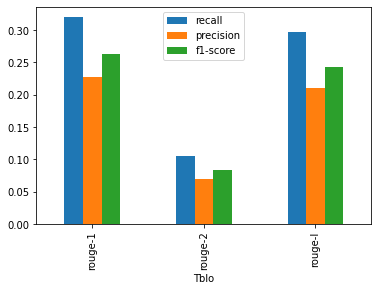

In [28]:
gh = pd.DataFrame({
    'Tblo': ['rouge-1', 'rouge-2', 'rouge-l'],
    'recall':list(val.iloc[0,[1,4,7]]),
    'precision':list(val.iloc[0,[0,3,6]]),
    'f1-score':list(val.iloc[0,[2,5,8] ])
})
  
# plotting graph
gh.plot(x="Tblo", y=["recall","precision","f1-score"], kind="bar")